*Created by Will Dinneen (willdinneen@gmail.com) for the PDRI-DevLab Junior Data Scientist Position @ UPenn (7/7/2023)*

# Overview

### Data Management

My data management process consisted of three key tasks: 1) recoding the "gender" variable, 2) merging the *case* and *demo* (demographics) datasets, and 3) restricting the data to only individuals who were arrested in Chicago. Ultimately, this process resulted in 25,000 unique cases that were used for the subsequent analysis.

**Recoding Gender**

The first task—recoding "gender"—was straightforward. First, I listed out all unique values in the orginal gender column (`['F' 'M' 'male' 'female']`) and then used Panda's built in `.replace()` method to recode them.

**Merging Datasets**

The subsequent tasks were more involved. When dealing with any unknown dataset, in this case the *case* and *demo* csv files, it is important to confirm the integrity of the data. Therefore before merging the datasets and restricing the rows to Chicago, I validated the data.

First, I confirmed that there were no missing "person_id" values in either of the datasets, as this would have broken the merge. 

Second, I checked whether there were duplicated "person_id" values in the demographic data, and found that, indeed, there were 4721 duplicate IDs. Fortunately, none of these IDs had any contradictory demographic information, and so I was able to safely drop the duplicates.

Finally, I confirmed that every "person_id" value in the case dataset was also represented in the demographic dataset.

With these validations complete, I executed a left join between *case* and *demo* on "person_id", sucessfully merging the two datasets. To confirm ths merge I utilized the `.isnull()` method in Pandas to confirm that there was not a single missing value in any column after the merge

**Restricting To Chicago**

To restrict the cases to only those in Chicago, I had to utilize the "address" column in the data.

First, I confirmed that the address format was consistent for every row, and that every address included a city value. 

I then extracted the City value from the address and transformed it into lowercase text to maintain consistency.

Ultimately, there were three represented cities: `['chicago' 'oak lawn' 'cicero']`. After restricting the data to only Chicago cases (stored in the df `chicago_df`), there were exactly 25,000 relevant cases.

### Variable Creation

The Variable Creation section consisted of three overaching tasks: 1) creating an "age" variable, 2) creating a measure for 9th & 10th grade GPAs for defendants between the ages of 18-24, and 3) reconstructing the "prior_arrest" and "re_arrest" columns.

**Creating The Age Variable**
To create the age variable, I first confirmed that all of the "bdate" and "arrest_date" values were formatted correctly. After that, I simply used Panda's `Timedelta` method to calculate the number of days between each row's "bdate" and "arrest_date", then divided by 365.25 & rounded down to the nearest integer to calculate age at the time of arrest. 

**Creating GPA Measures**
To create a GPA measure I needed to use a third dataset: *grades*. Like the others, I validated this data, confirming that there were no missing Person IDs and no duplicate Person IDs.

Next, I restricted the chicago cases dataset to only those cases where the age of the defendent was between 18 and 24 (inclusive). Unfortunately, 3006 of the IDs in this restricted case dataset were not present in the grades data, and so not every person's GPA was calculated. I exported these 3006 IDs to a new file `missing_grades_data_ids.csv` for future reference.

Next, I calculated the GPA for each row in the grades data by 1) converting each letter grade to a number, 2) filtering the relevant columns based on their prefix (e.g., `gr9` or `gr10`), and 3) caluclating the mean GPA for each grade level. 

Finally, I merged the the GPA data into the chicago case data on "person_id", adding the two new columns: `gr9_gpa` and `gr10_gpa`.

**Reconstructing Prior Arrests & Re-Arrest**

To recreate the Prior Arrests & Re-Arrest data, I needed to incorporate a fourth dataset, *prior_arrests*. Like the others, I began by validating this dataset, confirming that there were no missing IDs and that all prior arrest dates were in the correct format. I also confirmed that all person IDs in the prior arrests data existed in the chicago cases dataset.

Once the new data was validated, I reconstructed the prior arrests variable by: 1) grouping the prior arrest data by "person_id", 2) summing the number of arrests for each person id, 3) merging that data into the chicago case data, replacing empty rows with 0, and 4) added arrests that occured during the study period to the new "reconstructed_prior_arrests" column using a sorted (on arrest_date) copy of the chicago case data.

Next, I calculated the re-arrest value for each row to reconstruct the re-arrest variable. I did this by: 1) looping through each row of the chicago case data, 2) finding all subsequent cases with the same the "person_id", and 3) calculating whether those subsequent cases had an arrest date prior to the disposition data of the row in question.\
> Note: this calculation was not very efficient and took a longer time to run. This is becasue I am filtering the entire DF for every row (see the `calculate_re_arrests()` function). If I were to rewrite this to optimize for speed, I would rework the logic to calculate re_arrest on a DF grouped by person_id to avoid filtering the entire DF every time. 

Finally, I confirmed that both of these new values, `reconstructed_prior_arrests` and `reconstructed_re_arrest`, matched the original columns, `prior_arrests` and `re_arrest`, exactly. Ultimately, there were 0 differences between the reconstructed variables and the original variables.

### Statistical Analysis

Ultimately, the goal of this assignment was to evaluate whether the Attorney's Office's program actually reduced re-arrest among people with bail awaiting trial. This goal drove the process of actually analyzing the data.

**Describing Demographic Characteristics**
I began by describing the characteristics of the data in the following ways:
1. I calculated the basic descriptive statistics for Age and then created a histogram to visualize the distribution of age.
2. I created four tables that display the count & percentage of each Gender & Race variable.

The actual outputs can be seen in Figure 1 below. 

**Balance Testing Between Treatment & Control Groups**
To test the balance between treatment and control groups, that is, to confirm that there were no systematic differences in how defendents were assigned to each group, I utilized logistic regressions (Table 1) with assignment to the treatment group as my dependent variable.

Specifically, my null hypothesis was that: "Age, Gender, and Race had no effect on assignment to the treatment group."

For Gender and Race, I found no statistically significant evidence to reject this null hypotheses, indicating balance across these groups. 

However, for Age, I found that assignment to the treatment group was positively correlated with age (Age Coefficient = 0.053), and that this correlation was statistically significant. 

To explore this relationship further, I displays descriptive statistics (Table 2) for Age across both groups. I discovered that the mean age among untreated and treated groups was ~28 and ~31 respectively. While this difference is statistically significant there is not reason to beleive that this difference is substantively significant.

**Visualizing The Difference Between Groups**
Still, it is important to understand this imbalance in age, and so, to explore it further, I decided to use Age as my observable characteristic ro visualize. To do this, I plotted the density distribution of Age in both treated and control groups (Figure 2), demonstrating visually how the treated group is slightly older than the untreated group.

For good measure, I ran a T-Test on these two groups to confirm that the means were indeed significantly different.

**Evaluating The Treatment Effect**
Finally, I utilized logistic regression to evaluate the effectiveness of the program on re-arrest.

In this case, my null hypothesis was that: "Enrollment in the program had no affect on whether a defendent would be re-arrested prior to their deposition."

I included four covariates in my analysis: Age, Gender, Race, and Prior Arrest. These variables were chosen as all plausibly have a relationship to re-arrest. *Were this an actual study, I would ground my decision to add these covariates in a much stronger theoretical framework.*
> As Appendix Table 2 demonstrates, I also made sure to check for a non-linear relationship between age and rearrests by running a logistic regreassion with age-squared. Since I found no reason to beleive in a non-linear relationship, I left age-squared out of my final result.

Gender and Race, being categorical variables, were transform into dummy variables for inclusion in the model. Since "race_BLACK" constituted over 70% of my dataset, I  choose it as my reference variable to avoid collinearity. The variables "race_ASIAN" and "race_WHITE" were thus included in the model as my race covariates.

With these variables defined, I then ran a logistic regression with re-arrest as the dependent variable (Table 3).

Notably, the effect of the treatment (Coefficient = -0.094) was statistically significant, implying that we ought to reject the null hypothesis that the enrollment had no effect. The negative direction of this coefficient implies that, indeed, participating in the program reduced the likelihood of re-arrest.

**Evaluating Heterogeneous Treatment Effects**
After running the overall regression, I then turned toward exploring heterogenous treatement effects. This would prove useful for helping the State's Attorney's Office prioritize program spending across groups.

First, I evaluated heterogeneous treatment effects by creating interaction variables for each key group: Age, Gender, Race, and Prior Arrests. Like before, I ran a logistic regression (Table 4), including these interaction variables. For Age, Gender, and Race, I found no significant indication of heterogenous effects.

For Prior Arrests x Treatment, I found a slight (Coefficient = -0.07), statistically significant increase in the effectiveness of the program. In other words, it appears that the treatment might prove more effective for those with more prior arrests.

However, I was skeptical of these results, and was concerned that, since the case data was analyzed at the case level (i.e., the same person might appear multiple times in the data), that being a repeat offender was a possible confounder. Specifically,
1. Being a repeat offender might affect assignment to treatment as more arrests means more opportunities to be treated
2. Being a repeat offencer might affect re-arrest as repeat offenders might be more prone to arrest in general.

To evaluate this, a ran another logistic regression on the effect of treatment (Table 5), however, this time *I only included the very first offense for each defendent* (n = 14,353). By doing this I ensured true randomization in assignment to treatment, and avoided hidden effects such as carry-over effects from treatment during a prior arrest.

Among this group, I found a significantly stronger effect of treatment than within the group of all cases. Specifically, the treatment coefficient for the first-offence group was -0.146 whereas the coefficient for the overall group was -0.094.

Therefore, I would suggest that the State's Attorney's Office focus their efforts on only first time offenders. Not only would this reduce the cost of the program by nearly half, but it would likely have more pronounced results.

# Code

## Data Management

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import copy

# Datasets
case_df = pd.read_csv('../case.csv')
demo_df = pd.read_csv('../demo.csv')
prior_arrests_df = pd.read_csv('../prior_arrests.csv')
grades_df = pd.read_csv('../grades.csv')

In [2]:
# 1. Recode it so that males are consistently coded as “M” and females are consistently coded as “F”.

print("Gender column values pre-recode:")
print(demo_df["gender"].unique())

# Gender column recoding
gender_recode = {
    'male': 'M',
    'female': 'F'
}

demo_df["gender"] = demo_df["gender"].replace(gender_recode)

print("\nGender column values post-recode:")
print(demo_df["gender"].unique())

Gender column values pre-recode:
['F' 'M' 'male' 'female']

Gender column values post-recode:
['F' 'M']


In [3]:
# 2. Merge the case and demo datasets together so that each row in the case dataset also contains the demographics of the defendant.

# Confirm Data Integrity
print("---- Checking Data Integrity ----\n")

missing_demo_values = demo_df["person_id"].isnull().sum()
missing_case_values = case_df["person_id"].isnull().sum()
print(f"Missing demographic values: {missing_demo_values}")
print(f"Missing case values: {missing_case_values}")

duplicate_demo_ids = demo_df["person_id"].duplicated().sum()
print(f"\nDuplicate demographic ids: {duplicate_demo_ids}")
# Check to see if duplicated IDs are duplicated rows
duplicate_ids = demo_df[demo_df["person_id"].duplicated(keep=False)]
duplicated_rows = duplicate_ids[duplicate_ids.duplicated(keep=False)]
print(f"Number of contradictory demographic ids: {len(duplicate_ids) - len(duplicated_rows)}")

# Dropping duplicates
demo_df = demo_df.drop_duplicates()

# Measure Differences Accross Demo & Case data
print("\n\n---- Comparing Demographic & Case Representation ----\n")

unique_case_ids = case_df["person_id"].unique()
unique_demo_ids = demo_df["person_id"].unique()
print("Number of unique persons in case data:")
print(len(unique_case_ids))

print("\nNumber of unique persons in demographic data:")
print(len(unique_demo_ids))

print("\nDifference in number of unique persons in demographic vs case data:")
print(len(unique_demo_ids) - len(unique_case_ids))

# Identify extra demo IDs & save to file for later investigation 
extra_demo_ids = set(unique_demo_ids) - set(unique_case_ids)
extra_demo_ids_df = pd.DataFrame(extra_demo_ids, columns=['person_id'])
extra_demo_ids_df.to_csv('./outputs/extra_demo_ids.csv', index=False)

# Merge the df
merged_df = case_df.merge(demo_df, on='person_id', how='left')

# Check for missing values
print(f"\nMissing values after merge:\n{merged_df.isnull().sum()}")

---- Checking Data Integrity ----

Missing demographic values: 0
Missing case values: 0

Duplicate demographic ids: 4721
Number of contradictory demographic ids: 0


---- Comparing Demographic & Case Representation ----

Number of unique persons in case data:
15353

Number of unique persons in demographic data:
15715

Difference in number of unique persons in demographic vs case data:
362

Missing values after merge:
caseid           0
person_id        0
arrest_date      0
dispos_date      0
treat            0
re_arrest        0
prior_arrests    0
address          0
race             0
gender           0
bdate            0
dtype: int64


In [4]:
# 3. For the purpose of this analysis, please restrict the data to only individuals who were arrested in Chicago.

# Check the format of the address column
address_format_check = merged_df["address"].str.contains(", ")
print(f"Number of addresses with correct format: {address_format_check.sum()}")
print(f"Number of addresses with incorrect format: {(~address_format_check).sum()}")

# Extract the city from the address column
merged_df["city"] = merged_df["address"].str.split(", ").str[1]

# Confirm that all cities are the same case
merged_df["city"] = merged_df["city"].str.lower()

# Check to see if there are any misspelled values
print(f"\nRepresented cities: {merged_df['city'].unique()}")

# Extract all rows with arrests in Chicago
chicago_df = merged_df[merged_df["city"] == "chicago"].copy()

print(f"\nNumber of cases in Chicago: {len(chicago_df)}")

Number of addresses with correct format: 26000
Number of addresses with incorrect format: 0

Represented cities: ['chicago' 'oak lawn' 'cicero']

Number of cases in Chicago: 25000


## Variable Creation

In [5]:
# 1. Create an age variable equal to the defendant’s age at the time of arrest for each case.

# Validate bdate & arrest date format
chicago_df['bdate'] = pd.to_datetime(chicago_df['bdate'], errors='coerce')
if chicago_df['bdate'].isnull().sum() > 0:
    print("Some birth dates have an incorrect format.")
else:
    print("All birth dates have the correct format.")
    
chicago_df['arrest_date'] = pd.to_datetime(chicago_df['arrest_date'], errors='coerce')
if chicago_df['arrest_date'].isnull().sum() > 0:
    print("Some arrest dates have an incorrect format.")
else:
    print("All arrest dates have the correct format.")

# Create age variable
chicago_df['age'] = np.floor((chicago_df['arrest_date'] - chicago_df['bdate']) / pd.Timedelta(days=365.25))

All birth dates have the correct format.
All arrest dates have the correct format.


In [6]:
# 2. Please construct measures for 9th and 10th grade GPA for this target population.
grades_df

# Create the numeric grade scale
grade_scale_index = {
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
}
grades_df = grades_df.replace(grade_scale_index)

# Create gr9 and gr10 GPA measures
def calculate_gpa(df, grade_level):
    relevant_columns = df.filter(like=grade_level)
    gpa_column = relevant_columns.mean(axis=1, skipna=True).round(3)
    return gpa_column
grades_df['gr9_gpa'] = calculate_gpa(grades_df, 'gr9')
grades_df['gr10_gpa'] = calculate_gpa(grades_df, 'gr10')

chicago_df

# Validate grades data
print("---- Validating Grades Data ----\n")
missing_grades_ids = grades_df['person_id'].isnull().sum()
print(f"Number of missing IDs in grade data: {missing_grades_ids}")
duplicate_grades_ids = grades_df["person_id"].duplicated().sum()
print(f"Duplicate grades ids: {duplicate_grades_ids}")

# Check if all relevant ids exist in both datasets
filtered_chicago_df = chicago_df[(chicago_df['age'] >= 18) & (chicago_df['age'] <= 24)]
relevant_chicago_ids = set(filtered_chicago_df['person_id'])
grade_ids = set(grades_df['person_id'])
missing_grades_ids = relevant_chicago_ids - grade_ids
print(f"\nNumber of relevant IDs in Chicago data not represented in Grade data: {len(missing_grades_ids)}")
missing_grades_data_ids = pd.DataFrame(missing_grades_ids, columns=['person_id'])
missing_grades_data_ids.to_csv('./outputs/missing_grades_data_ids.csv', index=False)
print("Missing grades data IDs saved to file: ./outputs/missing_grades_data_ids.csv")

# Add GPA measures to chicago_df
filtered_chicago_df = pd.merge(filtered_chicago_df, grades_df[['person_id', 'gr9_gpa', 'gr10_gpa']], on='person_id', how='left')
chicago_df = pd.merge(chicago_df, filtered_chicago_df[['caseid', 'gr9_gpa', 'gr10_gpa']], on='caseid', how='left')

---- Validating Grades Data ----

Number of missing IDs in grade data: 0
Duplicate grades ids: 0

Number of relevant IDs in Chicago data not represented in Grade data: 3006
Missing grades data IDs saved to file: ./outputs/missing_grades_data_ids.csv


In [7]:
# 3.a. Please reconstruct the variable (prior arrests) using the prior_arrests.csv file. 

# Validate prior arrests data
print("---- Validating Prior Arrests Data ----\n")
missing_arrest_ids = prior_arrests_df['person_id'].isnull().sum()
print(f"Number of missing IDs in prior arrests data: {missing_arrest_ids}")

# Validate date format
prior_arrests_df['arrest_date'] = pd.to_datetime(prior_arrests_df['arrest_date'], errors='coerce')
if prior_arrests_df['arrest_date'].isnull().sum() > 0:
    print("\nSome arrest dates have an incorrect format.")
else:
    print("All arrest dates have the correct format.")
    
# Confirm that there is no overlap so as not to double count
print(f"\nMost recent prior_arrest_df date: {prior_arrests_df['arrest_date'].max()}")
print(f"Oldest chicago_df date: {chicago_df['arrest_date'].min()}")

# Check if all arrest ids exist in both datasets
prior_arrests_ids = set(prior_arrests_df['person_id'])
chicago_ids = set(chicago_df['person_id'])
if prior_arrests_ids.issubset(chicago_ids):
    print("\nAll person IDs from prior_arrests_df exist in chicago_df")
else:
    print("\nNot all person IDs from prior_arrests_df exist in chicago_df")

# Reconstruct prior_arrests variable
prior_arrest_counts = prior_arrests_df.groupby('person_id').size().reset_index(name='reconstructed_prior_arrests')
chicago_df = pd.merge(chicago_df, prior_arrest_counts, on='person_id', how='left')
chicago_df['reconstructed_prior_arrests'] = chicago_df['reconstructed_prior_arrests'].fillna(0)
chicago_df['reconstructed_prior_arrests'] = chicago_df['reconstructed_prior_arrests'].astype(int)

# Add arrests that occured during the study period
chicago_df_sorted = chicago_df.sort_values(['person_id', 'arrest_date'])
chicago_df_sorted['reconstructed_prior_arrests'] = chicago_df_sorted.groupby('person_id').cumcount() + chicago_df_sorted['reconstructed_prior_arrests']
chicago_df.loc[chicago_df_sorted.index, 'reconstructed_prior_arrests'] = chicago_df_sorted['reconstructed_prior_arrests']

# 3.b. Please reconstruct this indicator (re_arrest).

# Calculate whether each row was rearrested
def calculate_re_arrests(row):
    other_cases = chicago_df_sorted[chicago_df_sorted['person_id'] == row['person_id']]
    subsequent_cases = other_cases[other_cases['arrest_date'] > row['arrest_date']]
    re_arrests = subsequent_cases[subsequent_cases['arrest_date'] < row['dispos_date']]
    return len(re_arrests) > 0

chicago_df_sorted['reconstructed_re_arrest'] = chicago_df_sorted.apply(calculate_re_arrests, axis=1)
chicago_df_sorted['reconstructed_re_arrest'] = chicago_df_sorted['reconstructed_re_arrest'].astype(int)

chicago_df.loc[chicago_df_sorted.index, 'reconstructed_re_arrest'] = chicago_df_sorted['reconstructed_re_arrest']

# 3.c. Please show that the variables you reconstructed are equal to the versions in the provided datasets.

print("\n\n---- Validating Reconstructed Variables ----\n")

# Check prior_arrests variable
prior_arrests_differences = chicago_df[chicago_df['prior_arrests'] != chicago_df['reconstructed_prior_arrests']]
print(f"Number of differenes between prior_arrests & reconstructed_prior_arrests: {len(prior_arrests_differences)}")

# Check re_arrest variable
re_arrest_differences = chicago_df[chicago_df['re_arrest'] != chicago_df['reconstructed_re_arrest']]
print(f"Number of differenes between re_arrest & reconstructed_re_arrest: {len(re_arrest_differences)}")

---- Validating Prior Arrests Data ----

Number of missing IDs in prior arrests data: 0
All arrest dates have the correct format.

Most recent prior_arrest_df date: 2011-12-31 00:00:00
Oldest chicago_df date: 2012-01-02 00:00:00

All person IDs from prior_arrests_df exist in chicago_df


---- Validating Reconstructed Variables ----

Number of differenes between prior_arrests & reconstructed_prior_arrests: 0
Number of differenes between re_arrest & reconstructed_re_arrest: 0


## Statistical Analysis

### Figure 1 — Demographic Descriptions

---- Describing Demographics ----


Age: 
+-------+-------------+
|       |         age |
|-------+-------------|
| count | 25000       |
| mean  |    29.8221  |
| std   |     7.79954 |
| min   |     9       |
| 25%   |    24       |
| 50%   |    29       |
| 75%   |    35       |
| max   |    70       |
+-------+-------------+


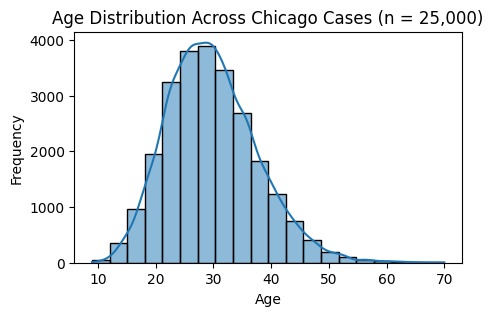


Gender Counts: 
+----+----------+
|    |   gender |
|----+----------|
| M  |    20064 |
| F  |     4936 |
+----+----------+

Gender Percentage: 
+----+----------+
|    |   gender |
|----+----------|
| M  |   80.256 |
| F  |   19.744 |
+----+----------+

Race Counts: 
+-------+--------+
|       |   race |
|-------+--------|
| BLACK |  18249 |
| WHITE |   5512 |
| ASIAN |   1239 |
+-------+--------+

Race Percentage: 
+-------+--------+
|       |   race |
|-------+--------|
| BLACK | 72.996 |
| WHITE | 22.048 |
| ASIAN |  4.956 |
+-------+--------+


In [8]:
# 1. Describe the demographic characteristics of the study population based on the data available to you.

print("---- Describing Demographics ----\n")

# Summary statistics
print("\nAge: ")
print(chicago_df['age'].describe().to_markdown(tablefmt="psql"))

# Age Histogram
plt.figure(figsize=(5,3))
sns.histplot(data=chicago_df, x="age", bins=20, kde=True)
plt.title("Age Distribution Across Chicago Cases (n = 25,000)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

print("\nGender Counts: ")
gender_counts = chicago_df['gender'].value_counts()
print(gender_counts.to_markdown(tablefmt="psql"))
print("\nGender Percentage: ")
gender_percentages = chicago_df['gender'].value_counts(normalize=True) * 100
print(gender_percentages.to_markdown(tablefmt="psql"))

print("\nRace Counts: ")
race_counts = chicago_df['race'].value_counts()
print(race_counts.to_markdown(tablefmt="psql"))
print("\nRace Percentage: ")
race_percentages = chicago_df['race'].value_counts(normalize=True) * 100
print(race_percentages.to_markdown(tablefmt="psql"))

### Tables 1 & 2 — Treatment & Control Group Balancing

In [9]:
# 1.a. Are the treatment and control groups balanced?

import statsmodels.api as sm
import pandas as pd

# Encode Race & Gender
chicago_df['gender_binary'] = chicago_df['gender'].astype('category').cat.codes
race_dummies = pd.get_dummies(chicago_df['race'], prefix='race')

# Drop black column to avoid perfect colinearity 
race_dummies = race_dummies.drop('race_BLACK', axis=1)

X = pd.concat([chicago_df[['age', 'gender_binary']], race_dummies], axis=1)
X = sm.add_constant(X)

y = chicago_df['treat']

# Fit the model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print("\nRegression Results for Predicting Treatement Assignment Based on Key Variable (Table 1):")
print(result.summary())

print("\n\nDescription of Age Across Groups (Table 2):")
print(chicago_df.groupby('treat')['age'].describe().to_markdown(tablefmt="psql"))

Optimization terminated successfully.
         Current function value: 0.672005
         Iterations 5

Regression Results for Predicting Treatement Assignment Based on Key Variable (Table 1):
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24995
Method:                           MLE   Df Model:                            4
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.02861
Time:                        11:34:22   Log-Likelihood:                -16800.
converged:                       True   LL-Null:                       -17295.
Covariance Type:            nonrobust   LLR p-value:                6.151e-213
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const       

### Figure 2 — Age Distribution by Enrollment Status

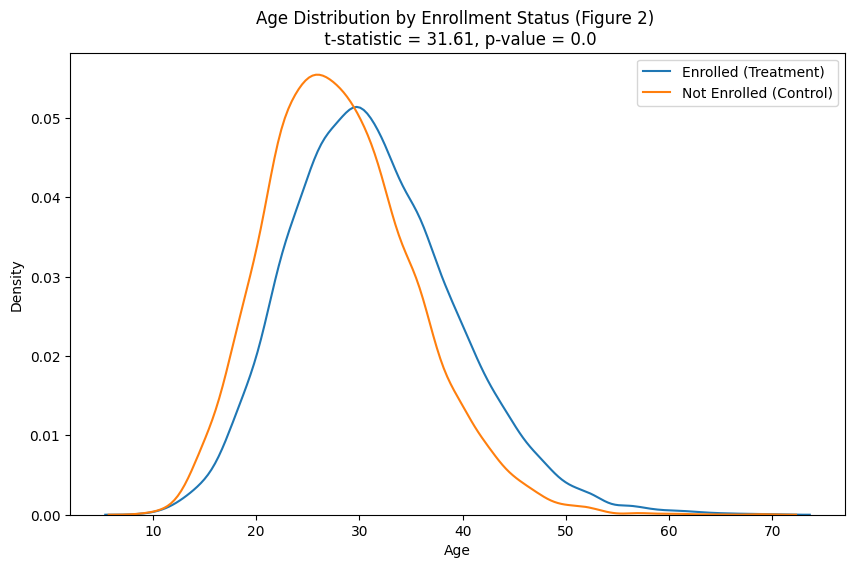

In [10]:
# 1.b. Choose one observable characteristic and visualize the difference between enrolled and not enrolled subjects.

treat_df = chicago_df[chicago_df['treat'] == 1]
control_df = chicago_df[chicago_df['treat'] == 0]

t_stat, p_val = stats.ttest_ind(treat_df['age'], control_df['age'])

# Plot
plt.figure(figsize=(10,6))
sns.kdeplot(treat_df['age'], label='Enrolled (Treatment)')
sns.kdeplot(control_df['age'], label='Not Enrolled (Control)')

plt.xlabel('Age')
plt.ylabel('Density')
plt.title(f'Age Distribution by Enrollment Status (Figure 2) \n t-statistic = {t_stat.round(2)}, p-value = {p_val.round(3)}')
plt.legend()
plt.show()

### Table 3 — Effect of Program Enrollment on Re-arrest

In [11]:
# 3. Did participating in the program reduce the likelihood of re-arrest before disposition? Explain your answer and your methodology.

print("---- Describing Treatment & Outcomes ----\n")

cross_tab = pd.crosstab(chicago_df['treat'], chicago_df['re_arrest'])
cross_tab.columns = ['re_arrest_0', 're_arrest_1']

# print(cross_tab.to_markdown(tablefmt="psql", index=None))

print(cross_tab.to_markdown(tablefmt="psql"))

print("\n\n---- Running Regression ----\n")

# Create covariates
race_dummies = pd.get_dummies(chicago_df['race'], prefix='race')
race_dummies = race_dummies.drop('race_BLACK', axis=1)

chicago_df = pd.concat([chicago_df, race_dummies], axis=1)

# Run a Logit Regression
X = chicago_df[['treat', 'age', 'gender_binary', 'prior_arrests', 'race_ASIAN', 'race_WHITE']]

y = chicago_df['re_arrest']
X = sm.add_constant(X)

# Fit model
model = sm.Logit(y, X)
result = model.fit()

# Print the model summary
print("\nEffect of Program Enrollment on Re-arrest (Table 3): ")
print(result.summary())

---- Describing Treatment & Outcomes ----

+---------+---------------+---------------+
|   treat |   re_arrest_0 |   re_arrest_1 |
|---------+---------------+---------------|
|       0 |          9459 |          2392 |
|       1 |         10288 |          2861 |
+---------+---------------+---------------+


---- Running Regression ----

Optimization terminated successfully.
         Current function value: 0.504746
         Iterations 6

Effect of Program Enrollment on Re-arrest (Table 3): 
                           Logit Regression Results                           
Dep. Variable:              re_arrest   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24993
Method:                           MLE   Df Model:                            6
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.01823
Time:                        11:34:22   Log-Likelihood:                -12619.
converged:                    

### Table 4 — Evaluating Interactions Between Treatment and Various Groups

In [12]:
# 4. Using the data available to you, what recommendation would you make regarding who to serve?

# Check for interactions
interaction_df = chicago_df.copy()

for col in ['age', 'gender_binary', 'prior_arrests', 'race_ASIAN', 'race_WHITE']:
    interaction_df[f'treat_{col}'] = interaction_df['treat'] * interaction_df[col]

# Now we'll add these interaction terms into our regression model
X = interaction_df[['treat', 
                    'age', 
                    'treat_age',
                    'gender_binary',
                    'treat_gender_binary',
                    'prior_arrests', 
                    'treat_prior_arrests', 
                    'race_ASIAN', 
                    'treat_race_ASIAN',
                    'race_WHITE',
                    'treat_race_WHITE'
                   ]]

y = interaction_df['re_arrest']
X = sm.add_constant(X)

# Fit the model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary
print("\nEvaluating Interactions Between Treatment and Various Groups (Table 4): ")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.504372
         Iterations 6

Evaluating Interactions Between Treatment and Various Groups (Table 4): 
                           Logit Regression Results                           
Dep. Variable:              re_arrest   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24988
Method:                           MLE   Df Model:                           11
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.01895
Time:                        11:34:22   Log-Likelihood:                -12609.
converged:                       True   LL-Null:                       -12853.
Covariance Type:            nonrobust   LLR p-value:                 1.733e-97
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const           

### Table 5 — Effect of Enrollment on Re-Arrest For Only First-Time Offenders

In [13]:
# Examining the effect of treatment if we only look at the first offense

print("---- Describing Treatment & Outcomes ----\n")

chicago_df_first_offence = chicago_df.drop_duplicates(subset='person_id', keep='first')
cross_tab = pd.crosstab(chicago_df_first_offence['treat'], chicago_df_first_offence['re_arrest'])
cross_tab.columns = ['re_arrest_0', 're_arrest_1']

# print(cross_tab.to_markdown(tablefmt="psql", index=None))

print(cross_tab.to_markdown(tablefmt="psql"))

print("\n\n---- Running Regression ----\n")

# Run a Logit Regression

# X = chicago_df_first_offence['treat']
X = chicago_df_first_offence[['treat', 'age', 'gender_binary', 'prior_arrests', 'race_ASIAN', 'race_WHITE']]

y = chicago_df_first_offence['re_arrest']
X = sm.add_constant(X)

# Fit model
model = sm.Logit(y, X)
result = model.fit()

# Print the model summary
print("\nEffect of Enrollment on Re-Arrest For Only First-Time Offenders (Table 5): ")
print(result.summary())

---- Describing Treatment & Outcomes ----

+---------+---------------+---------------+
|   treat |   re_arrest_0 |   re_arrest_1 |
|---------+---------------+---------------|
|       0 |          5973 |          1609 |
|       1 |          5058 |          1713 |
+---------+---------------+---------------+


---- Running Regression ----

Optimization terminated successfully.
         Current function value: 0.494843
         Iterations 6

Effect of Enrollment on Re-Arrest For Only First-Time Offenders (Table 5): 
                           Logit Regression Results                           
Dep. Variable:              re_arrest   No. Observations:                14353
Model:                          Logit   Df Residuals:                    14346
Method:                           MLE   Df Model:                            6
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.08536
Time:                        11:34:22   Log-Likelihood:                -7102.5
converge

## Appendix

### Appendix Table 1 — Effect of Multiple Offences on Likelyhood to Recieve Treatment

In [14]:
# Checking to see if multiple offenders are more likely to receive treatment
chicago_df_by_person_id = chicago_df.groupby('person_id').agg({'treat': 'max', 
                                                                'prior_arrests': "max",
                                                                're_arrest': "max",
                                                                'race': "first",
                                                                'gender': "first",
                                                                'age': "first"
                                                              }).reset_index()
chicago_df_by_person_id['multiple_offence'] = chicago_df['person_id'].duplicated(keep=False).astype(int)

X = chicago_df_by_person_id['multiple_offence']
X = sm.add_constant(X)

y = chicago_df_by_person_id['treat']

# Fit the model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print("\nEffect of Multiple Offences on Likelyhood to Recieve Treatment (Appendix Table 1): ")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.654386
         Iterations 4

Effect of Multiple Offences on Likelyhood to Recieve Treatment (Appendix Table 1): 
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                14353
Model:                          Logit   Df Residuals:                    14351
Method:                           MLE   Df Model:                            1
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:               9.871e-05
Time:                        11:34:22   Log-Likelihood:                -9392.4
converged:                       True   LL-Null:                       -9393.3
Covariance Type:            nonrobust   LLR p-value:                    0.1733
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const      

### Appendix Figure 1 — Count of Single and Multiple Offenders in Treatment and Control Groups

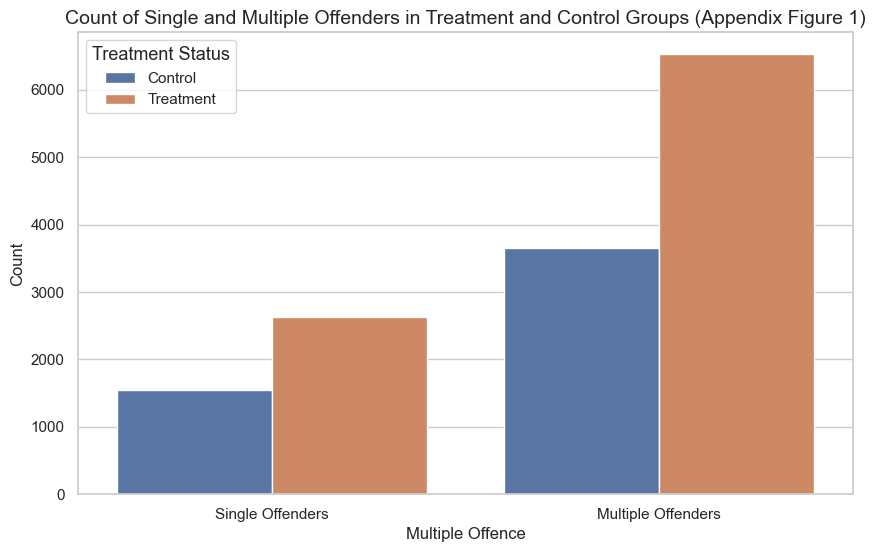

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
ax = sns.countplot(x="multiple_offence", hue="treat", data=chicago_df_by_person_id)

# Adding legends, titles and labels for clarity
ax.set_title('Count of Single and Multiple Offenders in Treatment and Control Groups (Appendix Figure 1)', fontsize=14)
ax.set_xlabel('Multiple Offence', fontsize=12)
ax.set_xticklabels(['Single Offenders', 'Multiple Offenders'])
ax.set_ylabel('Count', fontsize=12)
plt.legend(title='Treatment Status', title_fontsize='13', labels=['Control', 'Treatment'])

plt.show()

### Appendix Table 2 — Evaluating Non-Linear Relationships Between Age

In [16]:
# Running some robustness checks

print("---- Checking For Non-Linear Relationship in Age -----")

chicago_df["age_squared"] = chicago_df["age"] ** 2

# Run a Logit Regression
X = chicago_df[['treat', 'age', 'age_squared']]

y = chicago_df['re_arrest']
X = sm.add_constant(X)

# Fit model
model = sm.Logit(y, X)
result = model.fit()

# Print the model summary
print(result.summary())

---- Checking For Non-Linear Relationship in Age -----
Optimization terminated successfully.
         Current function value: 0.506494
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              re_arrest   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24996
Method:                           MLE   Df Model:                            3
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.01482
Time:                        11:34:22   Log-Likelihood:                -12662.
converged:                       True   LL-Null:                       -12853.
Covariance Type:            nonrobust   LLR p-value:                 2.789e-82
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.6589      0.182    -14.603      0